In [0]:
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d sadeghjalalian/wine-customer-segmentation
!unzip wine-customer-segmentation.zip

Saving kaggle.json to kaggle.json
  0% 0.00/4.42k [00:00<?, ?B/s]
100% 4.42k/4.42k [00:00<00:00, 4.28MB/s]
Archive:  wine-customer-segmentation.zip
  inflating: Wine.csv                


In [0]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline


# Import the test and train datasets into pandas dataframe
df_wine = pd.read_csv('/content/Wine.csv', header=0, sep=',', quotechar='"')

The dataset loaded for the unsupervised challenge is a Wine Segmentation dataset with 13 chemical constituent of wine coming from same region of Italy. The wine variety comes from three different cultivars which we:
1. Cluster using unsupervised learning methods and dimensional reduction methods
2. Cross validation using the available labels. 
3. Tune hyperparameter to get optimal clustering

In our case, the label of each variety come from "Customer_Segment" feature ranging in numbers 1, 2 and 3.

In total, the datasets contains 178 observation with 13 feature. There is a possibility that the similarity between datapoint could be relative low due to less observation and may pose issues with effectively clustering the datapoint distribution. Hence tuning the hyperparameters maybe required to get the best clustering results.

In [0]:
df_wine

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,3
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,3
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,3
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,3


#Exploratory Data Analysis

Overall, the dataset is clean to analyze and work with. Plotting the histogram of each chemical constituents shows the distibution to be more or less normal. Some skewness is observed for Malic Acid, Flavanoids and OD280, however no strong asymmetricity is shown

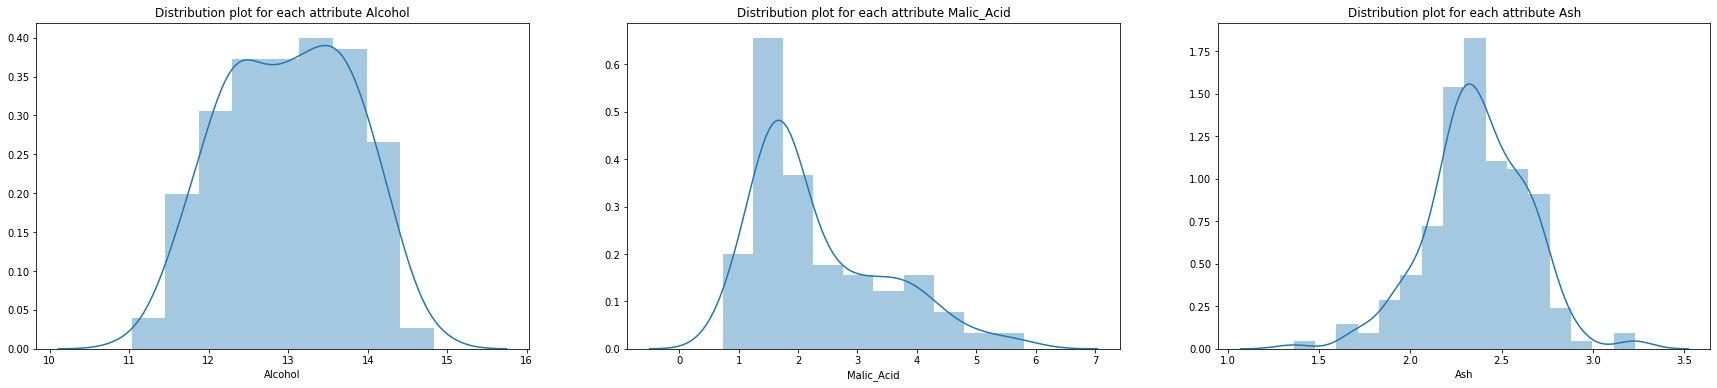

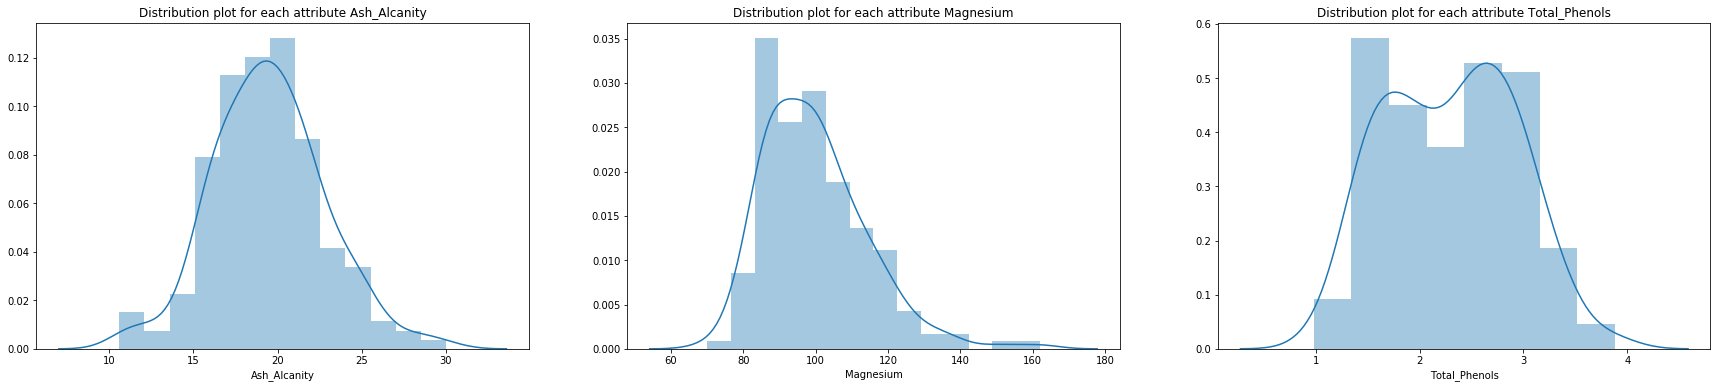

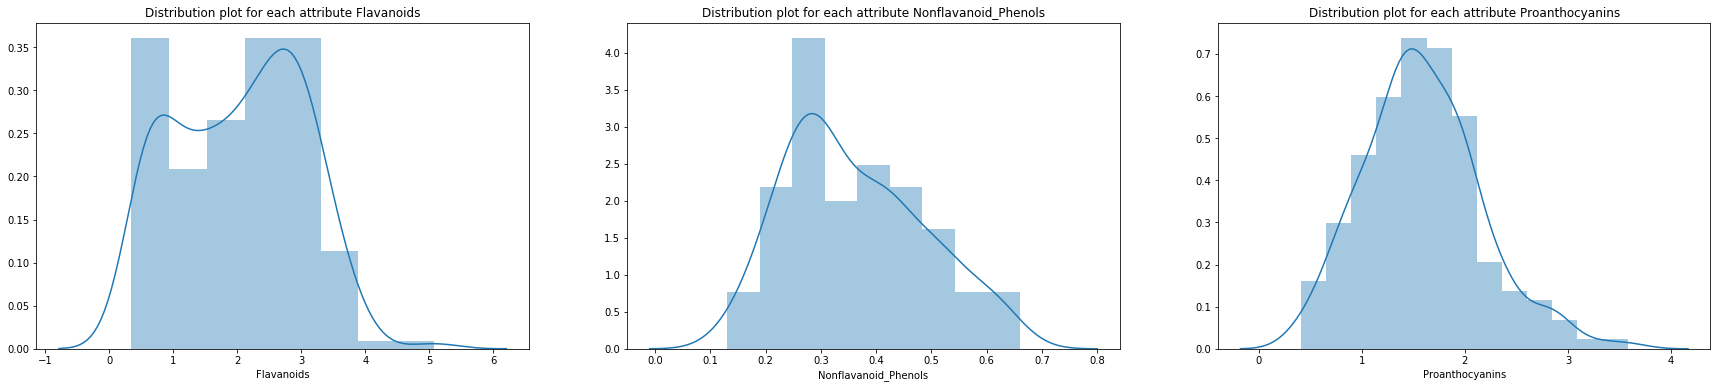

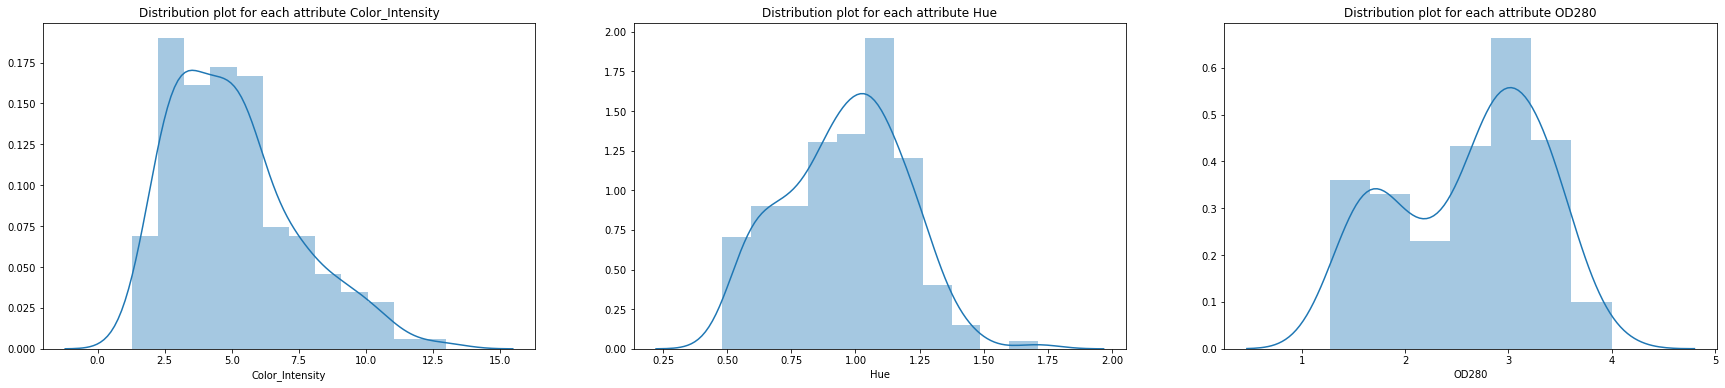

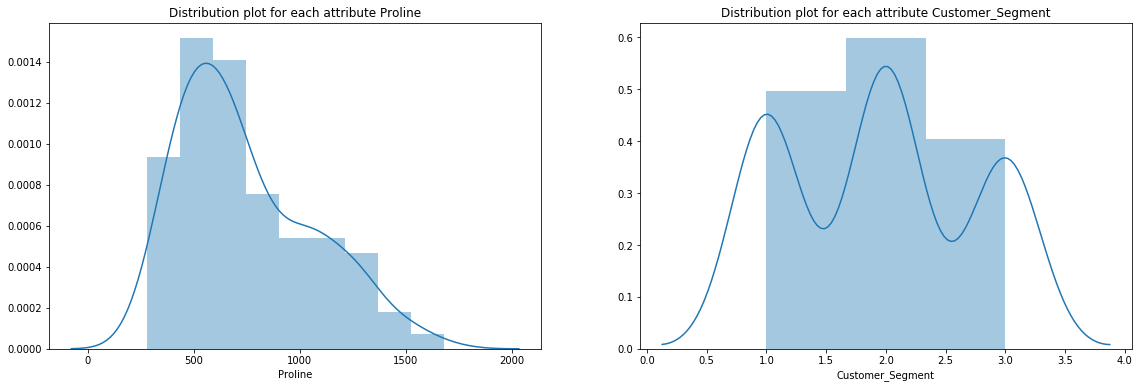

In [0]:
# Plotting categorical plot after filling missing nan values

cnt = 0
for col in df_wine.columns :
  cnt += 1
  if cnt ==1 :
    plt.figure(figsize=(30,6))
  plt.subplot(1, 3, cnt)
  sns.distplot(df_wine[col])
  plt.title("Distribution plot for each attribute "+col)
  if cnt ==3 :
    plt.show()
    cnt=0

The plot shows the barplot of each constituent against the label "Customer_Segment". More or less the variance of constituents varies among the labels and no common pattern emerges from these observation.

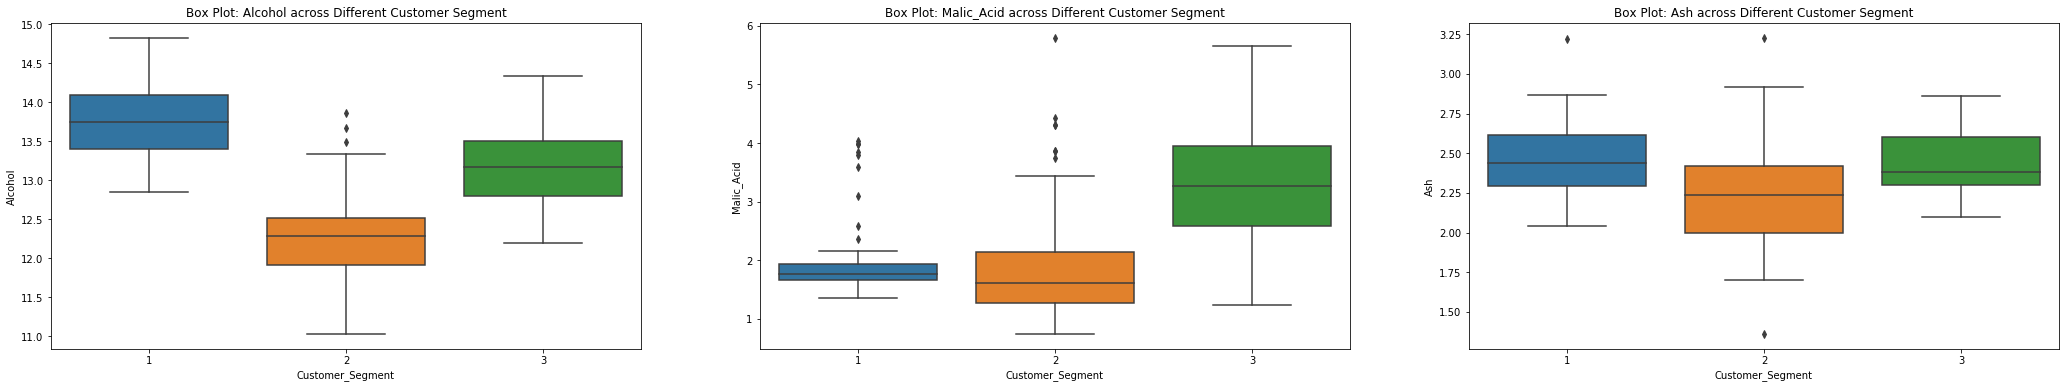

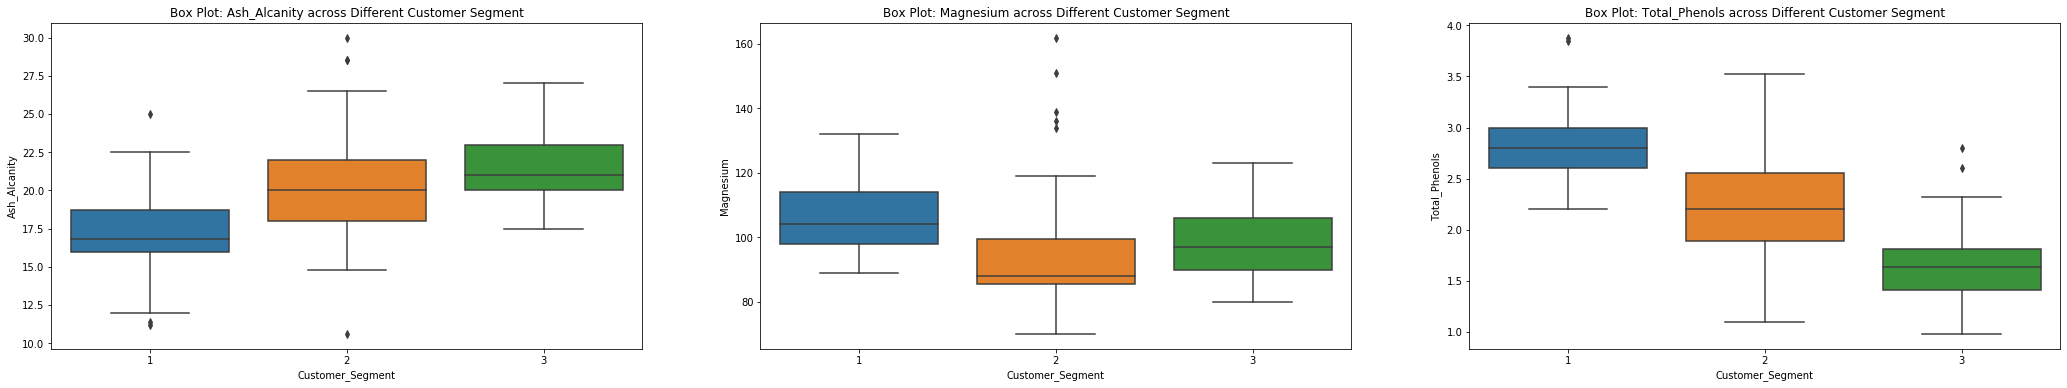

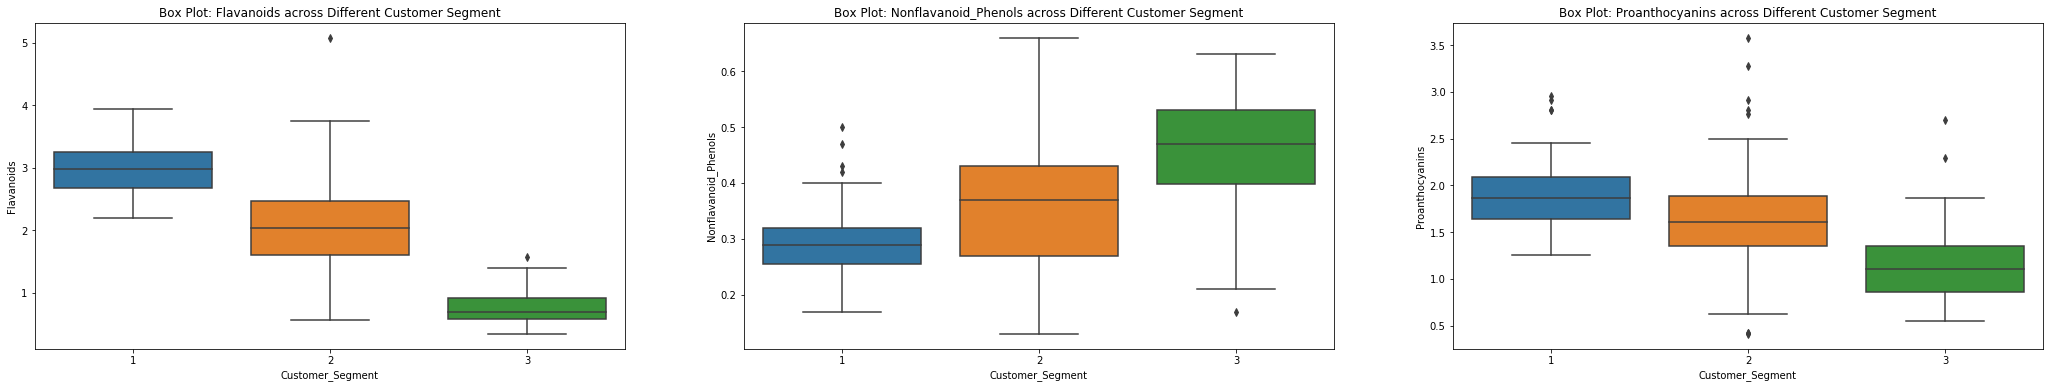

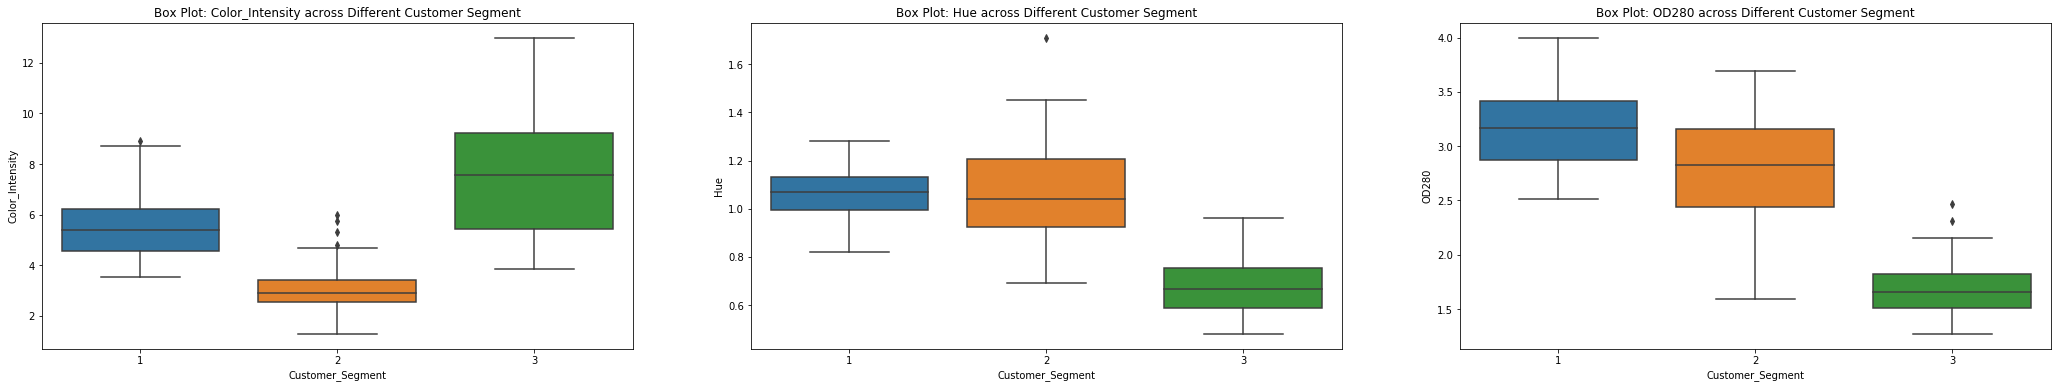

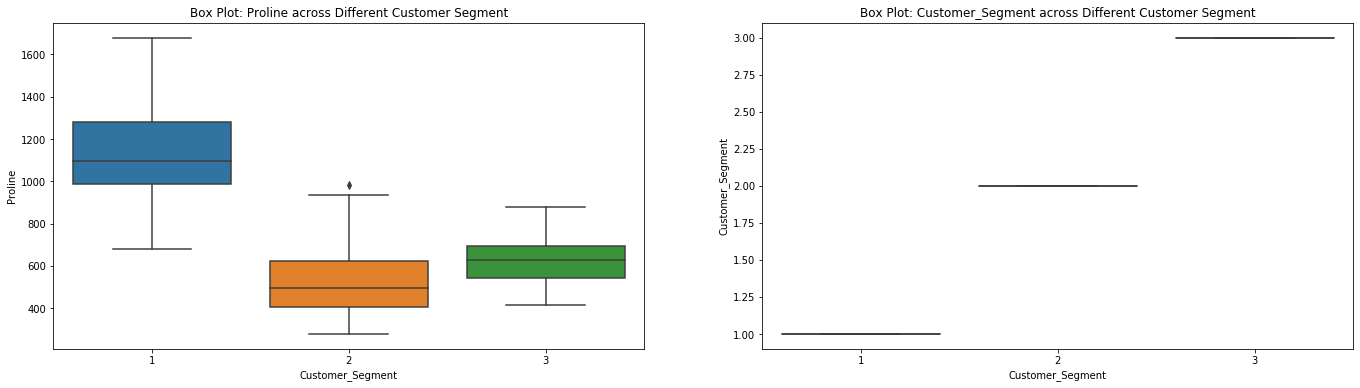

In [0]:
cnt = 0
for col in df_wine.columns :
  cnt += 1
  if cnt ==1 :
    plt.figure(figsize=(36,6))
  plt.subplot(1, 3, cnt)
  ax = sns.boxplot(y=col, x="Customer_Segment",data=df_wine)
  plt.title('Box Plot: '+col+' across Different Customer Segment')
  if cnt ==3 :
    plt.show()
    cnt=0


In [0]:
df_wine.groupby('Customer_Segment').mean()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
Customer_Segment,,,,,,,,,,,,,
1,13.744746,2.010678,2.455593,17.037288,106.338983,2.840169,2.982373,0.290000,1.899322,5.528305,1.062034,3.157797,1115.711864
2,12.278732,1.932676,2.244789,20.238028,94.549296,2.258873,2.080845,0.363662,1.630282,3.086620,1.056282,2.785352,519.507042
3,13.153750,3.333750,2.437083,21.416667,99.312500,1.678750,0.781458,0.447500,1.153542,7.396250,0.682708,1.683542,629.895833


# Dimensionality Reduction Methods

We first work on reducing the dimensionality and visualize the clustering of datapoints. 
First step is split the features with target and  standardize the input feature to avoid scaling related inaccuracies.

In [0]:
# Standardize
col = df_wine.columns
X = df_wine[col[:13]]
y = df_wine[col[13]]

# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

We tested three methods of reducing the data dimensios
1. Principal Component Analysis 

In [0]:
# We just want the first two principal components
pca = PCA(n_components=2)

# We get the components by 
# calling fit_transform method with our data
pca_components = pca.fit_transform(X_std)

2. tSNE Method

In [0]:
# tSNE dimensional reduction
from sklearn.manifold import TSNE
import time
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(X_std)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.625735
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.403259
[t-SNE] KL divergence after 300 iterations: 0.396444
t-SNE done! Time elapsed: 0.4470224380493164 seconds


3. UMAP Method

In [0]:
# Umap dimensional reduction
import time
!pip install umap-learn
import umap
time_start = time.time()

umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))

UMAP done! Time elapsed: 4.075272798538208 seconds


When visualizing the datapoints against the first two reduced dimensions, we observe the tSNE and UMAP methods perform better than PCA. The three cluster are overall distinguishable and linearly separable unlike PCA where the clustering are somewhat overlapped at boundary.

This also points us to the fact that the dimensionality reduction is able to capture the clustering pattern (including PCA) despite having relatively low obervations in the dataset to work with

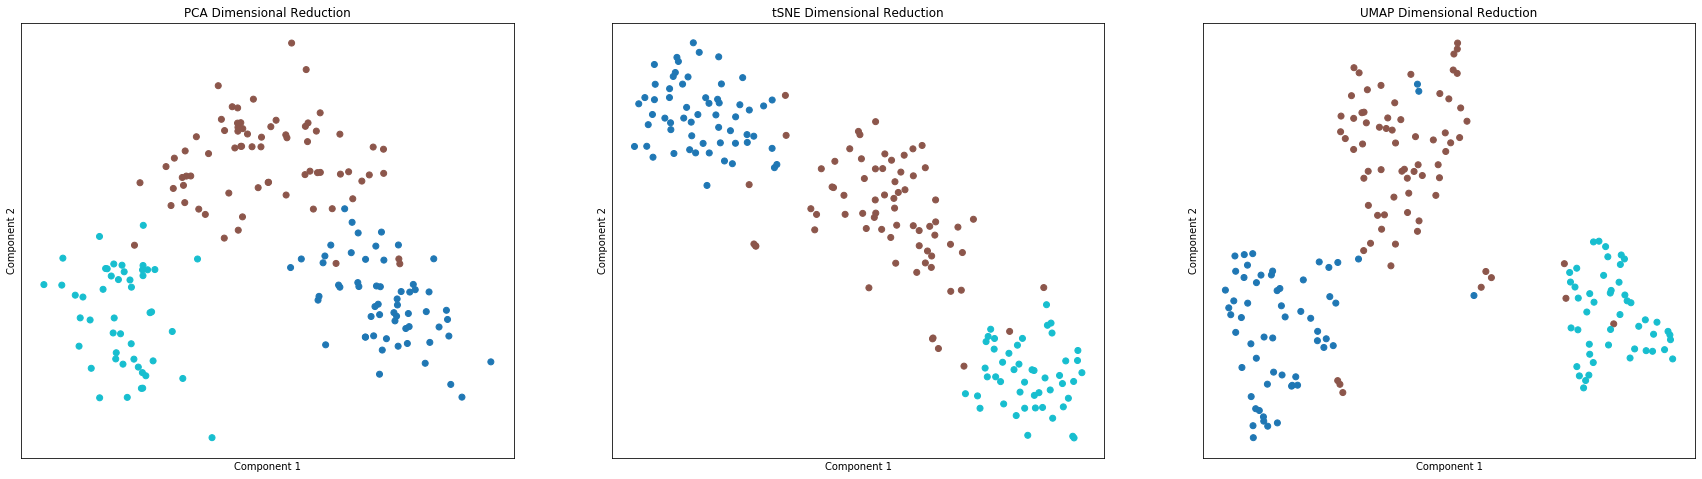

In [0]:
fig = plt.figure(figsize=(30,8))
plt.subplot(1, 3, 1)
plt.scatter(pca_components[:,0], pca_components[:,1],c=y,cmap='tab10')
plt.xticks([])
plt.yticks([])
plt.title("PCA Dimensional Reduction")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
#plt.axis('off')
plt.subplot(1, 3, 2)
plt.scatter(tsne_results[:,0], tsne_results[:,1],c=y,cmap='tab10')
plt.xticks([])
plt.yticks([])
plt.title("tSNE Dimensional Reduction")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
#plt.axis('off')
plt.subplot(1, 3, 3)
plt.scatter(umap_results[:,0], umap_results[:,1],c=y,cmap='tab10')
plt.xticks([])
plt.yticks([])
plt.title("UMAP Dimensional Reduction")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

## Hyper Parameter Tuning in Dimensionality Reduction
1. t-SNE performance
- Testing Perplexity from 1 to 50: Perplexity of 30 is the optimal value to use
- Testing number of iteration from 250 to 2000: 300 iteration is sufficient

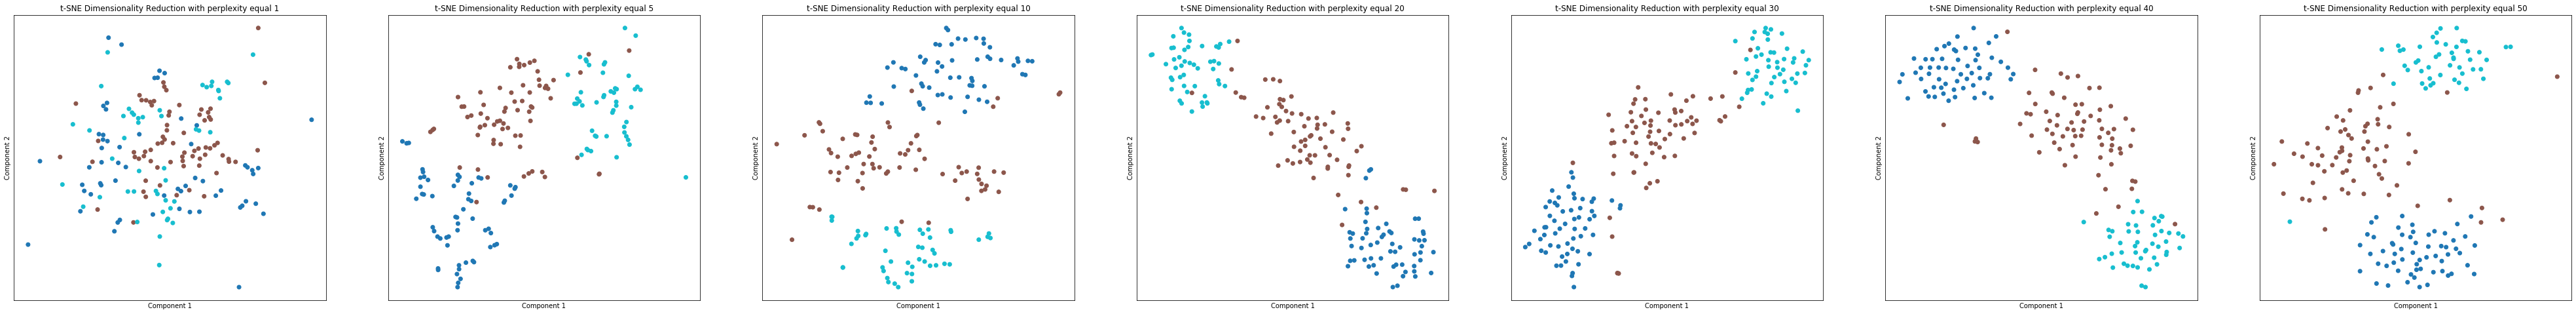

In [0]:
perpl = [1,5,10,20,30,40,50]
plt.figure(figsize=(10*len(perpl),8))
cnt = 0
for val in perpl:
  cnt += 1
  tsne = TSNE(n_components=2, verbose=0, perplexity=val, n_iter=300)
  tsne_results = tsne.fit_transform(X_std)
  # Plot tsne results
  plt.subplot(1, len(perpl), cnt)
  plt.scatter(tsne_results[:,0], tsne_results[:,1],c=y,cmap='tab10')
  plt.xticks([])
  plt.yticks([])
  plt.title("t-SNE Dimensionality Reduction with perplexity equal "+str(val))
  plt.xlabel("Component 1")
  plt.ylabel("Component 2")
plt.show()

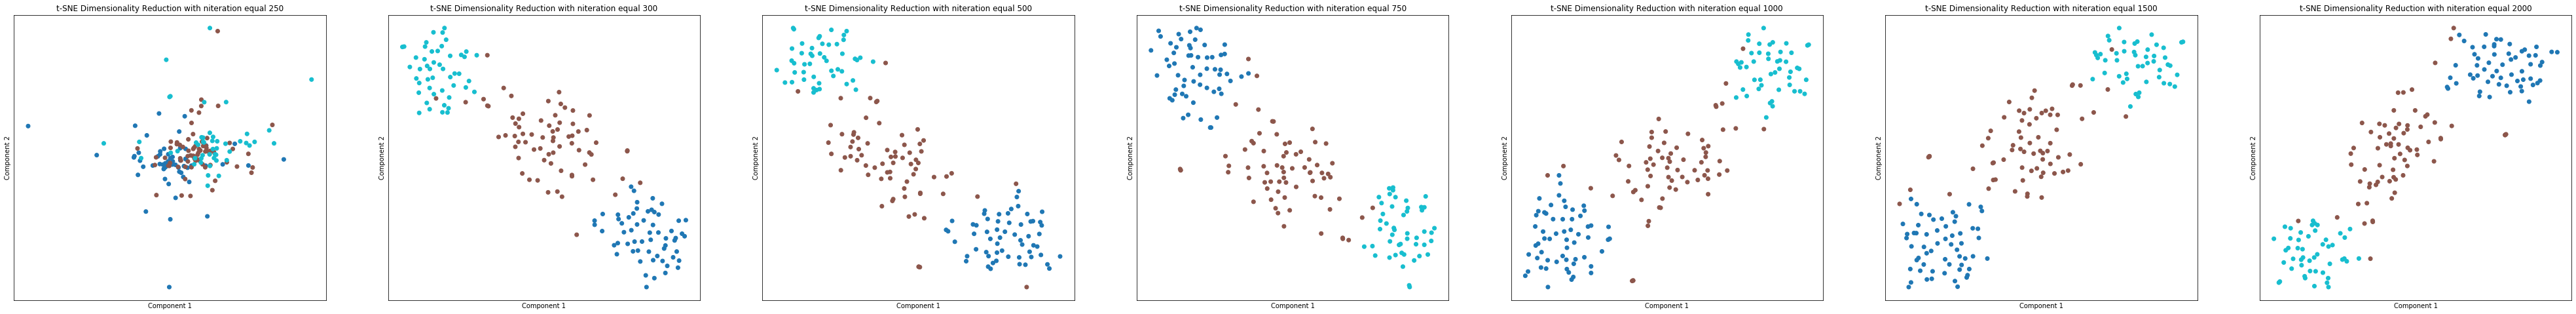

In [0]:
iiter = [250,300,500,750,1000,1500,2000]
plt.figure(figsize=(10*len(iiter),8))
cnt = 0
for val in iiter:
  cnt += 1
  tsne = TSNE(n_components=2, verbose=0, perplexity=30, n_iter=val)
  tsne_results = tsne.fit_transform(X_std)
  # Plot tsne results
  plt.subplot(1, len(iiter), cnt)
  plt.scatter(tsne_results[:,0], tsne_results[:,1],c=y,cmap='tab10')
  plt.xticks([])
  plt.yticks([])
  plt.title("t-SNE Dimensionality Reduction with niteration equal "+str(val))
  plt.xlabel("Component 1")
  plt.ylabel("Component 2")
plt.show()

2. UMAP Performance
- Testing n_neighbours from 2 to 50: n_neigh = 5 give the best result
- Testing min_dist from 0.0 to 0.9: min dist of 0.1 is choosen
- Testing metric: Correlation based metric is choosen

/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 41 separate connected components using meta-embedding (experimental)
  n_components


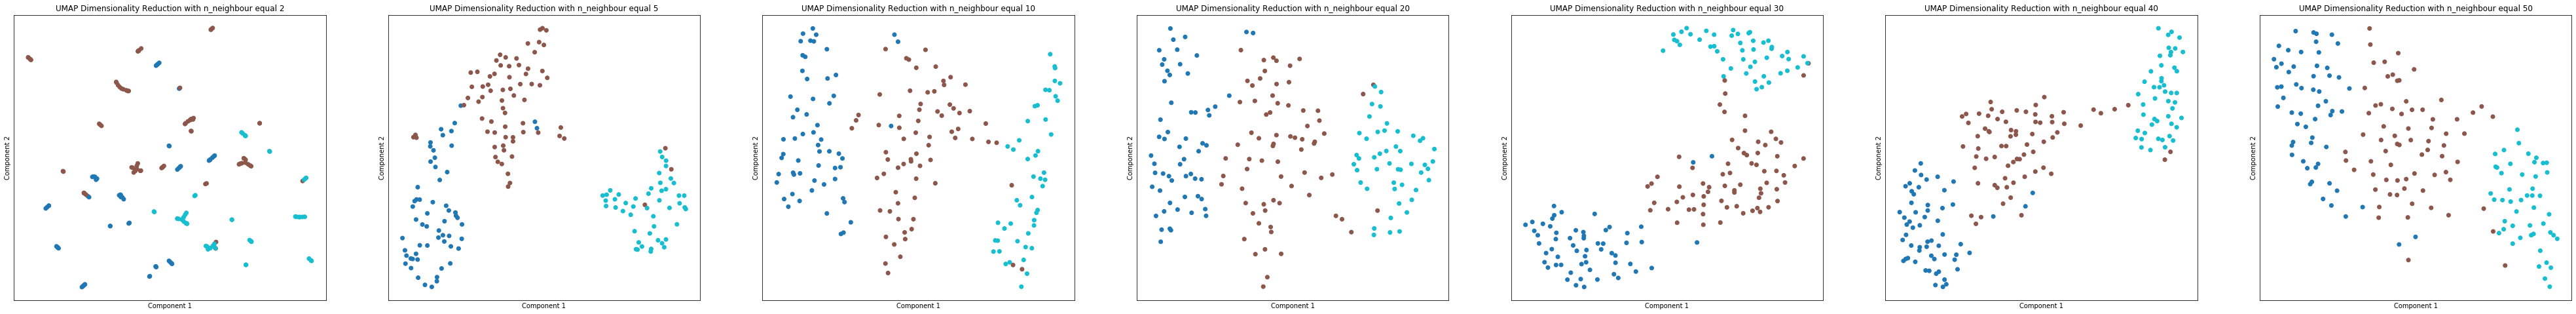

In [0]:
num_neigh = [2,5,10,20,30,40,50]
plt.figure(figsize=(10*len(num_neigh),8))
cnt = 0
for val in num_neigh:
  cnt += 1
  umap_results = umap.UMAP(n_neighbors=val,min_dist=0.3,metric='correlation').fit_transform(X_std)
  # Plot tsne results
  plt.subplot(1, len(num_neigh), cnt)
  plt.scatter(umap_results[:,0], umap_results[:,1],c=y,cmap='tab10')
  plt.xticks([])
  plt.yticks([])
  plt.title("UMAP Dimensionality Reduction with n_neighbour equal "+str(val))
  plt.xlabel("Component 1")
  plt.ylabel("Component 2")
plt.show()

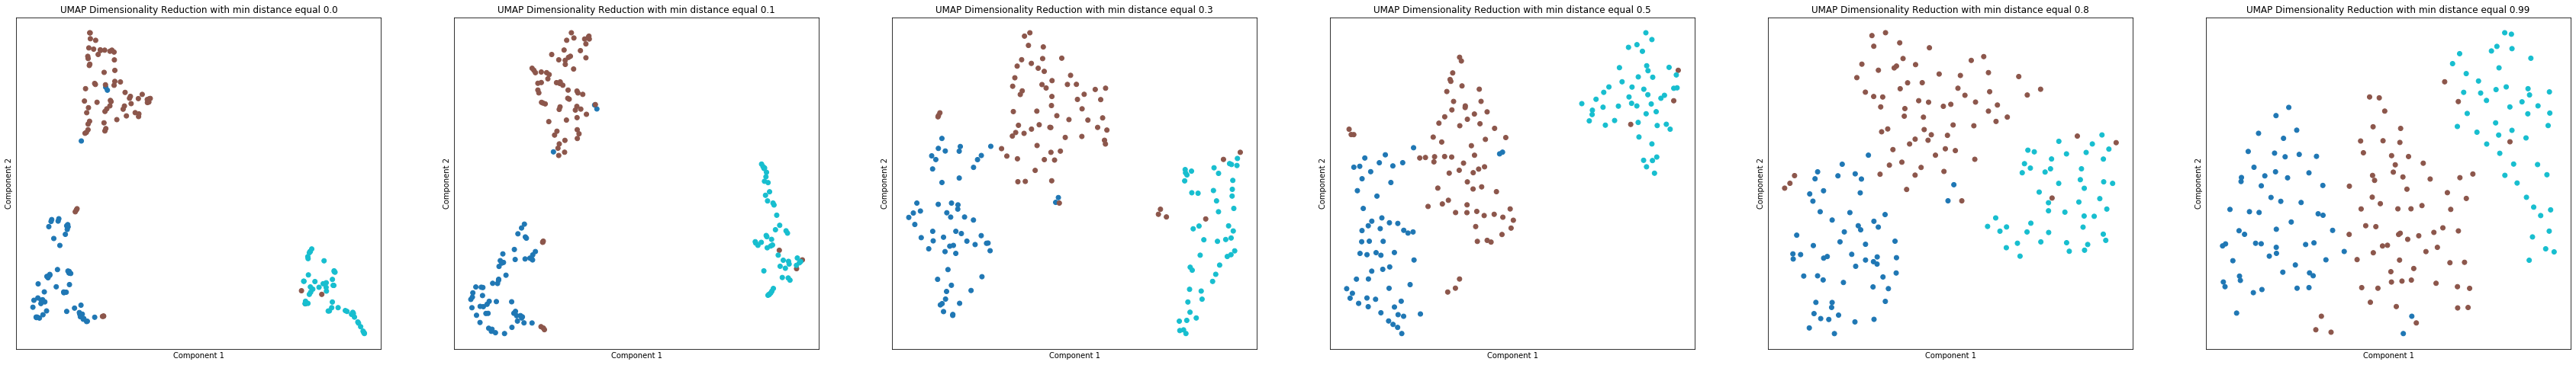

In [0]:
dist = [0.0, 0.1, 0.3, 0.5, 0.8, 0.99]
plt.figure(figsize=(10*len(dist),8))
cnt = 0
for val in dist:
  cnt += 1
  umap_results = umap.UMAP(n_neighbors=5,min_dist=val,metric='correlation').fit_transform(X_std)
  # Plot tsne results
  plt.subplot(1, len(dist), cnt)
  plt.scatter(umap_results[:,0], umap_results[:,1],c=y,cmap='tab10')
  plt.xticks([])
  plt.yticks([])
  plt.title("UMAP Dimensionality Reduction with min distance equal "+str(val))
  plt.xlabel("Component 1")
  plt.ylabel("Component 2")
plt.show()

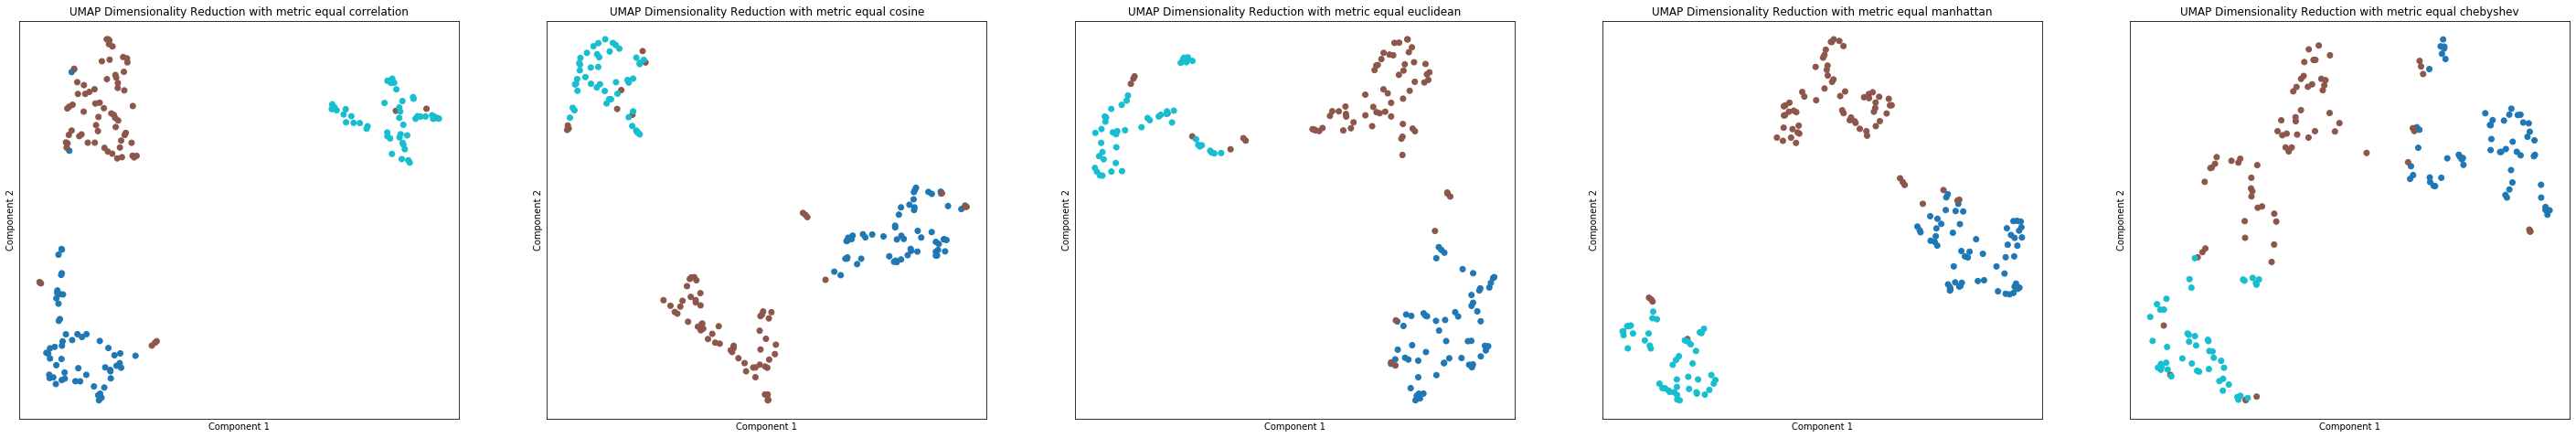

In [0]:
met = ['correlation','cosine','euclidean','manhattan','chebyshev']
plt.figure(figsize=(10*len(met),8))
cnt = 0
for val in met:
  cnt += 1
  umap_results = umap.UMAP(n_neighbors=5,min_dist=0.1,metric=val).fit_transform(X_std)
  # Plot tsne results
  plt.subplot(1, len(met), cnt)
  plt.scatter(umap_results[:,0], umap_results[:,1],c=y,cmap='tab10')
  plt.xticks([])
  plt.yticks([])
  plt.title("UMAP Dimensionality Reduction with metric equal "+str(val))
  plt.xlabel("Component 1")
  plt.ylabel("Component 2")
plt.show()

Finally, based on the tuned parameters the clustering is visualized in 3D plot with x,y corresponding to lower dimensions and z being the label. Overall UMAP has low datapoints scatter with a few outliers 

<Figure size 720x576 with 0 Axes>

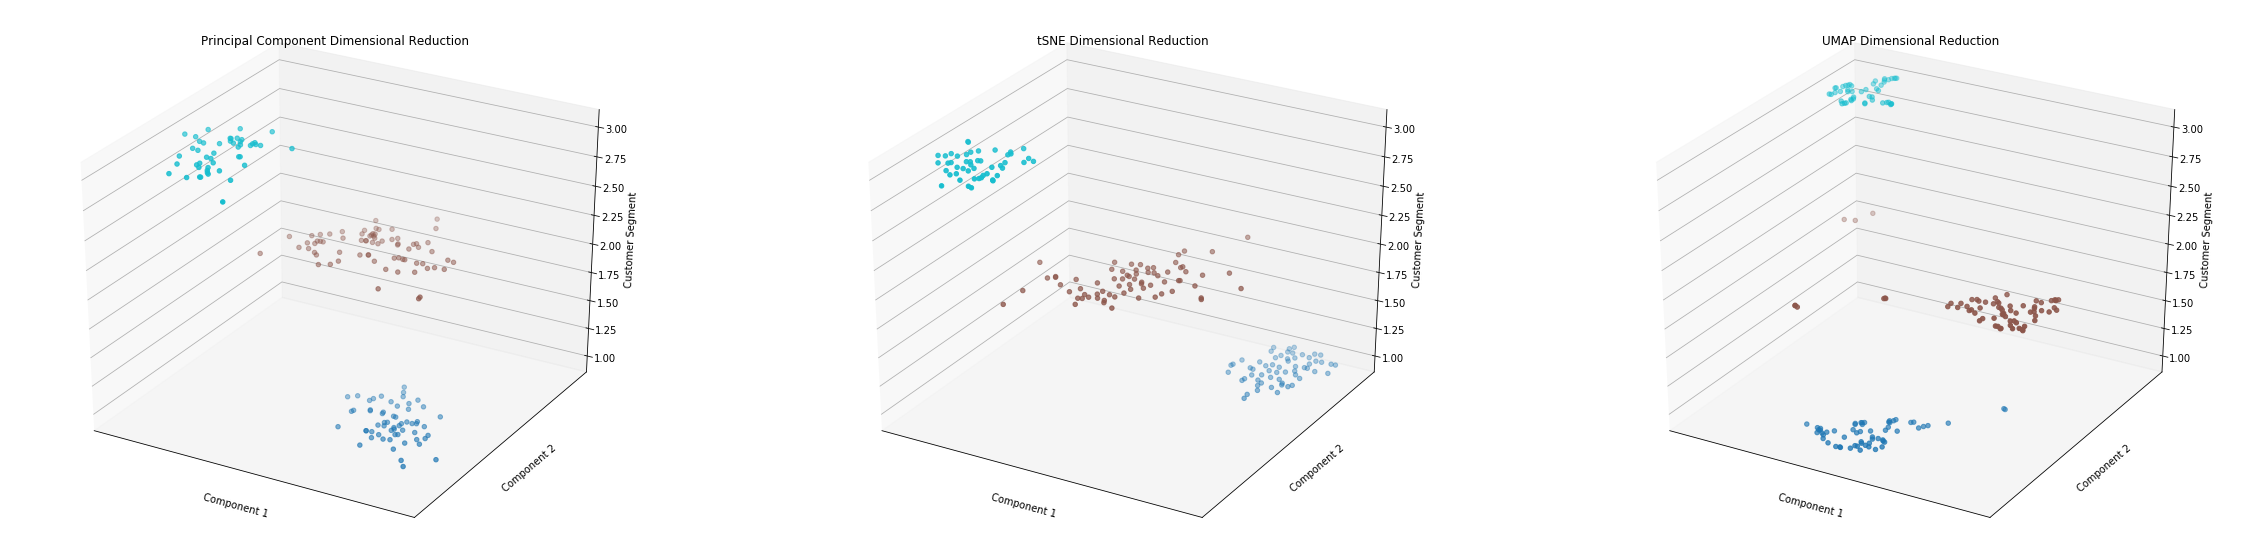

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
#plt.scatter(pca_components[:,0], pca_components[:,1], c=y)
#fig = plt.figure()

pca_components = PCA(n_components=2).fit_transform(X_std)
tsne_results = TSNE(n_components=2, verbose=0, perplexity=30, n_iter=300).fit_transform(X_std)
umap_results = umap.UMAP(n_neighbors=5,min_dist=0.1,metric='correlation').fit_transform(X_std)

fig = plt.figure(figsize=(40,10))
ax = fig.add_subplot(131, projection="3d")
ax.scatter(pca_components[:,0], pca_components[:,1], y,c=y,cmap = 'tab10')
plt.xticks([])
plt.yticks([])
plt.title('Principal Component Dimensional Reduction')
plt.xlabel("Component 1")
plt.ylabel("Component 2")
ax.set_zlabel('Customer Segment')
#plt.axis('off')
ax = fig.add_subplot(132, projection="3d")
ax.scatter(tsne_results[:,0], tsne_results[:,1], y,c=y,cmap = 'tab10')
plt.xticks([])
plt.yticks([])
plt.title('tSNE Dimensional Reduction')
plt.xlabel("Component 1")
plt.ylabel("Component 2")
ax.set_zlabel('Customer Segment')
#plt.axis('off')
ax = fig.add_subplot(133, projection="3d")
ax.scatter(umap_results[:,1], umap_results[:,0], y,c=y,cmap = 'tab10')
plt.xticks([])
plt.yticks([])
plt.title('UMAP Dimensional Reduction')
plt.xlabel("Component 1")
plt.ylabel("Component 2")
ax.set_zlabel('Customer Segment')
plt.show()

# Unsupervised Learning

In the following section, we test four clustering methods on our datasets. 
1. K Means
2. Hierarchical 
3. DBSCAN
4. GMM 

As a blind test we removed the label "Customer_Segment" and work with the 13 total constituents of wine


In [0]:
# Function for Ploting clustering
def pca_plot(X_std, y, y_pred,title):  
  pca = PCA(n_components=2).fit_transform(X_std)
  plt.figure(figsize=(1,1))
  colours = 'rbg'
  for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(y_pred[i]),color=colours[y[i]-1],fontdict={'weight': 'bold', 'size': 10})
  plt.text(np.min(np.array(pca[:, 0])), np.max(np.array(pca[:, 1])), title,fontdict={'weight': 'bold', 'size': 20})
  plt.xticks([])
  plt.yticks([])
  plt.axis('off')
  plt.show()

#1. K Means Method

From the datasets we know that n_cluster = 3 will yield the true answer. However, this is blind test and we test for varies values of n_cluster

In [0]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import datasets, metrics
# Defining the k-means
kmeans_cluster = KMeans(n_clusters=3, random_state=123)

# Fit model
%timeit kmeans_cluster.fit(X_std)
y_pred = kmeans_cluster.predict(X_std)

10 loops, best of 3: 27.4 ms per loop


In [0]:
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

Comparing k-means clusters against the data:
Customer_Segment   1   2   3
row_0                       
0                  0   3  48
1                  0  65   0
2                 59   3   0


Testing for varying n_cluster values. 
- ARI score for k mean = 3 is the highest of all 0.8975
- Silhouette score for k means = 3 is highest with 0.285 

In [0]:
# Defining the k-means
cluster_numbers = [2,3,4,5,6]
kmeans_clusters = []
for i in cluster_numbers:
    k_means = KMeans(n_clusters=i, random_state=123)
    full_pred = k_means.fit_predict(X_std)
    print ("ARI score on the K means of {} is {}".format(i,metrics.adjusted_rand_score(y, full_pred)))

ARI score on the K means of 2 is 0.3743144926213686
ARI score on the K means of 3 is 0.8974949815093207
ARI score on the K means of 4 is 0.7326487212804287
ARI score on the K means of 5 is 0.6657080913332526
ARI score on the K means of 6 is 0.6056001179283039


In [0]:
# Defining the k-means
cluster_numbers = [2,3,4,5,6]
for i in cluster_numbers:
    k_means = KMeans(n_clusters=i, random_state=123)
    full_pred = k_means.fit_predict(X_std)
    print ("silhouette score on the K means of {} is {}".format(i,metrics.silhouette_score(X_std, full_pred, metric='euclidean')))

silhouette score on the K means of 2 is 0.25931695553182543
silhouette score on the K means of 3 is 0.2848589191898987
silhouette score on the K means of 4 is 0.24970568859167702
silhouette score on the K means of 5 is 0.22875918503023265
silhouette score on the K means of 6 is 0.19111489612277593


Also looking at the consistency plots, k means equal 3 gives reasonably similat cluster patterns

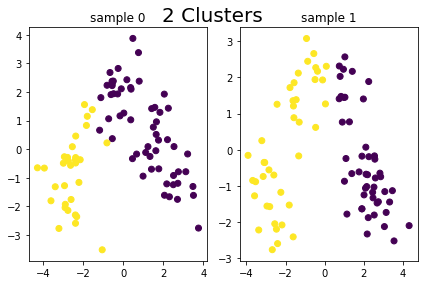

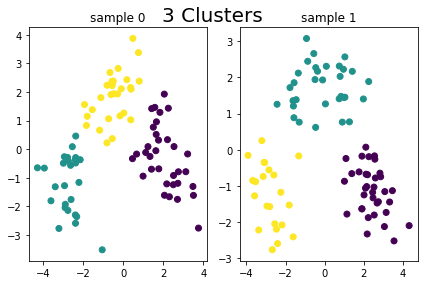

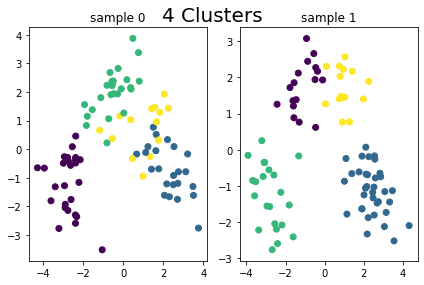

In [0]:
from sklearn.model_selection import train_test_split
# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(X_std,pca_components,test_size=0.5,random_state=1)

# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# PCA solution in the data frame.
for counter, data in enumerate([
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(data[counter])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

Finally the prediction (from modelling, in numbers) is consistent with the labels (from dataset, in colors). This implies that K mean modelling perform reasonable good in grouping the wine samples into 3 varieties

10 loops, best of 3: 27.8 ms per loop


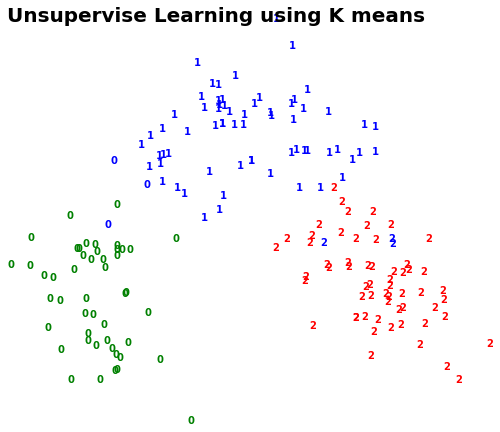

In [0]:
kmeans_cluster = KMeans(n_clusters=3, random_state=123)

# Fit model
%timeit kmeans_cluster.fit(X_std)
y_pred = kmeans_cluster.predict(X_std)

pca_plot(X_std,y,y_pred,'Unsupervise Learning using K means')

#2. Hierarchical Clusters


From the dendrogram, we infer that the ward linkage produces a well balanced datapoint clustering  

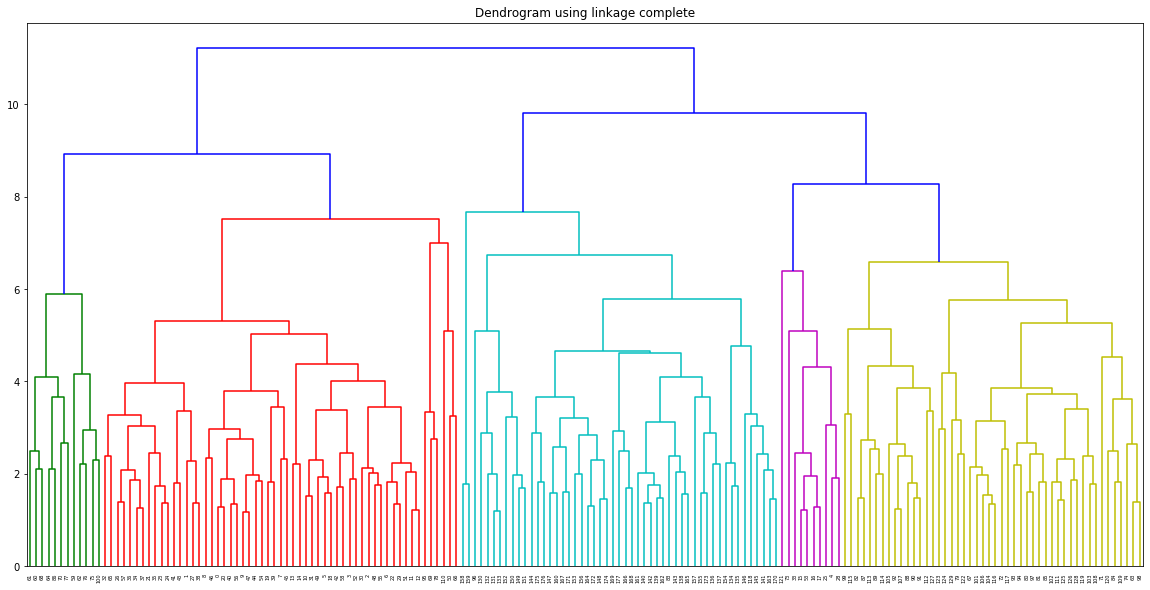

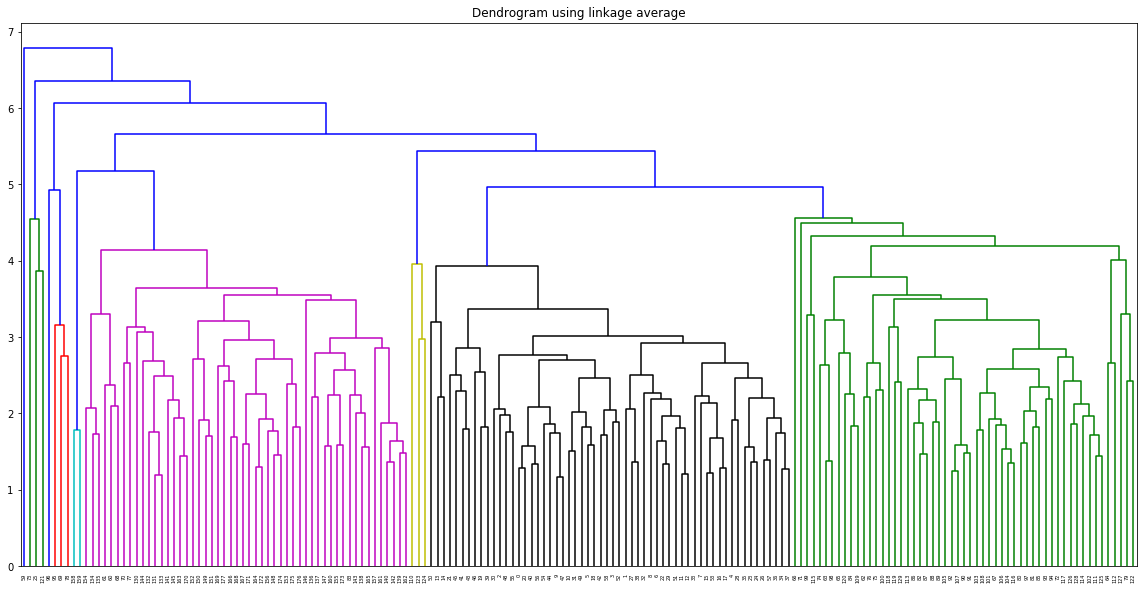

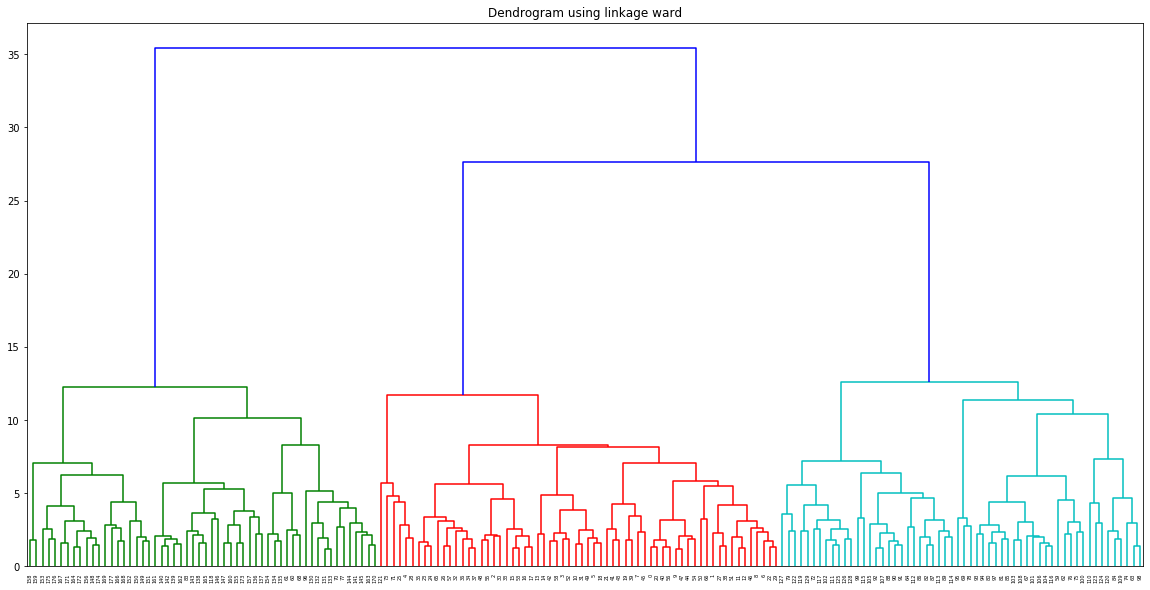

In [0]:
from scipy.cluster.hierarchy import dendrogram, linkage
mat = ['complete','average','ward']
for ind in mat:
  plt.figure(figsize=(20,10))
  dendrogram(linkage(X_std, method=ind))
  plt.title('Dendrogram using linkage '+ind)
  plt.show()

Testing for varying n_cluster values
- ARI score for Agglomerate Cliustering = 3 is the highest of all 0.789
- Silhouette score for Agglomerate Clustering = 3 is highest with 0.277  

In [0]:
from sklearn.cluster import AgglomerativeClustering

cluster_numbers = [2,3,4,5,6]
for ind in cluster_numbers:
  y_pred = AgglomerativeClustering(linkage='ward', affinity='euclidean',n_clusters=ind).fit_predict(X_std)
  print ("ARI score on the Agglomerate clustering of cluster {} is {}".format(ind,metrics.adjusted_rand_score(y, y_pred)))

ARI score on the Agglomerate clustering of cluster 2 is 0.4394391043947633
ARI score on the Agglomerate clustering of cluster 3 is 0.7899332213582837
ARI score on the Agglomerate clustering of cluster 4 is 0.6568168355341232
ARI score on the Agglomerate clustering of cluster 5 is 0.5830332574134743
ARI score on the Agglomerate clustering of cluster 6 is 0.5756786718964091


In [0]:
cluster_numbers = [2,3,4,5,6]
for ind in cluster_numbers:
  y_pred = AgglomerativeClustering(linkage='ward', affinity='euclidean',n_clusters=ind).fit_predict(X_std)
  print ("silhouette score on Agglomerate clustering of linkage {} is {}".format(ind,metrics.silhouette_score(X_std, y_pred, metric='euclidean')))

silhouette score on Agglomerate clustering of linkage 2 is 0.2670131771272231
silhouette score on Agglomerate clustering of linkage 3 is 0.2774439826952265
silhouette score on Agglomerate clustering of linkage 4 is 0.225836659334758
silhouette score on Agglomerate clustering of linkage 5 is 0.18674235566758707
silhouette score on Agglomerate clustering of linkage 6 is 0.17966642854438503


Testing for Different Linkage and as showns form the dendrogram the ward linkage gives high ARI and silhouette scores

In [0]:
mat = ['complete','average','ward']
for ind in mat:
  # Defining the agglomerative clustering
  if ind == 'ward' :
    y_pred = AgglomerativeClustering(linkage=ind, affinity='euclidean',n_clusters=3).fit_predict(X_std)
  else:
    y_pred = AgglomerativeClustering(linkage=ind, affinity='cosine',n_clusters=3).fit_predict(X_std)
  print ("ARI score on the Agglomerate clustering of linkage {} is {}".format(ind,metrics.adjusted_rand_score(y, y_pred)))

ARI score on the Agglomerate clustering of linkage complete is 0.5972483421815707
ARI score on the Agglomerate clustering of linkage average is 0.7847063550518786
ARI score on the Agglomerate clustering of linkage ward is 0.7899332213582837


In [0]:
mat = ['complete','average','ward']
for ind in mat:
  # Defining the agglomerative clustering
  if ind == 'ward' :
    y_pred = AgglomerativeClustering(linkage=ind, affinity='euclidean',n_clusters=3).fit_predict(X_std)
  else:
    y_pred = AgglomerativeClustering(linkage=ind, affinity='cosine',n_clusters=3).fit_predict(X_std)
  print ("silhouette score on Agglomerate clustering of linkage {} is {}".format(ind,metrics.silhouette_score(X_std, y_pred, metric='euclidean')))

silhouette score on Agglomerate clustering of linkage complete is 0.24425920956454214
silhouette score on Agglomerate clustering of linkage average is 0.26445785904779395
silhouette score on Agglomerate clustering of linkage ward is 0.2774439826952265


Cluster plot using Agglomerate clustering is reasonable

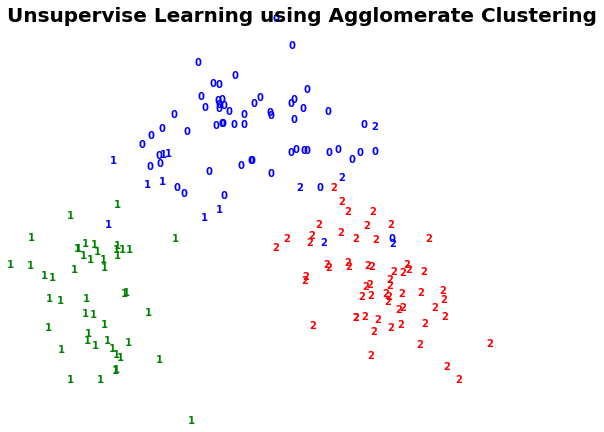

In [0]:
y_pred = AgglomerativeClustering(linkage='ward', affinity='euclidean',n_clusters=3).fit_predict(X_std)
pca_plot(X_std,y,y_pred,'Unsupervise Learning using Agglomerate Clustering')

#3. DB Scan Method

Testing for epsilon
- ARI score for DB scan of eps = 2 is the highest at 0.221
- Silhouette score for DBscan of eps = 4 is highest with 0.222

In [0]:
from sklearn.cluster import DBSCAN

eps = np.arange (2,5,1)
for ind in eps:
  # Defining the agglomerative clustering with fixed min_sample = 5
  dbscan_cluster = DBSCAN(eps=ind, min_samples=5)
  y_pred = dbscan_cluster.fit_predict(X_std)
  print ("ARI score of DB Scan using eps {} is {}".format(ind,metrics.adjusted_rand_score(y, y_pred)))

ARI score of DB Scan using eps 2 is 0.2204912298549749
ARI score of DB Scan using eps 3 is -0.005929398352149344
ARI score of DB Scan using eps 4 is -0.005179350377350294


In [0]:
eps = np.arange (2,5,1)
for ind in eps:
  # Defining the agglomerative clustering with fixed min_sample = 5
  dbscan_cluster = DBSCAN(eps=ind, min_samples=5)
  y_pred = dbscan_cluster.fit_predict(X_std)
  print ("silhouette score on DB Scan using eps {} is {}".format(ind,metrics.silhouette_score(X_std, y_pred, metric='euclidean')))

silhouette score on DB Scan using eps 2 is -0.03290613998220972
silhouette score on DB Scan using eps 3 is 0.21836446281240493
silhouette score on DB Scan using eps 4 is 0.2224506072765093


Testing for minpt
- ARI score for DB scan of minpt = 7 is the highest at 0.305
- Silhouette score for DBscan of minpt = 9 is highest with 0.137

In [0]:
minpt = np.arange (1,11,1)
for ind in minpt:
  # Defining the agglomerative clustering with fixed min_sample = 5
  dbscan_cluster = DBSCAN(eps=2, min_samples=ind)
  y_pred = dbscan_cluster.fit_predict(X_std)
  print ("ARI score of DB Scan using minpt {} is {}".format(ind,metrics.adjusted_rand_score(y, y_pred)))

ARI score of DB Scan using minpt 1 is 0.22559934541903118
ARI score of DB Scan using minpt 2 is 0.28359749537910145
ARI score of DB Scan using minpt 3 is 0.2866700918419873
ARI score of DB Scan using minpt 4 is 0.2581005515581199
ARI score of DB Scan using minpt 5 is 0.2204912298549749
ARI score of DB Scan using minpt 6 is 0.2167034210984639
ARI score of DB Scan using minpt 7 is 0.3052285180926511
ARI score of DB Scan using minpt 8 is 0.28772021604095466
ARI score of DB Scan using minpt 9 is 0.2695782857563212
ARI score of DB Scan using minpt 10 is 0.24264108190743092


In [0]:
minpt = np.arange (1,11,1)
for ind in minpt:
  # Defining the agglomerative clustering with fixed min_sample = 5
  dbscan_cluster = DBSCAN(eps=2, min_samples=ind)
  y_pred = dbscan_cluster.fit_predict(X_std)
  print ("silhouette score on DB Scan using minpt {} is {}".format(ind,metrics.silhouette_score(X_std, y_pred, metric='euclidean')))

silhouette score on DB Scan using minpt 1 is -0.13608258046150953
silhouette score on DB Scan using minpt 2 is -0.08807449052298841
silhouette score on DB Scan using minpt 3 is 0.031407450868970094
silhouette score on DB Scan using minpt 4 is 0.028566718532402113
silhouette score on DB Scan using minpt 5 is -0.03290613998220972
silhouette score on DB Scan using minpt 6 is -0.050778606609269625
silhouette score on DB Scan using minpt 7 is -0.027448250143437512
silhouette score on DB Scan using minpt 8 is -0.062497816633526874
silhouette score on DB Scan using minpt 9 is 0.13696497115564155
silhouette score on DB Scan using minpt 10 is 0.11450994046394997


Looking at the silhouette and ARI scores DBscan performs poorly with respect to K means and Agglomerate Clustering.

From the cluster plot we also many outlier values (tagged as -1)

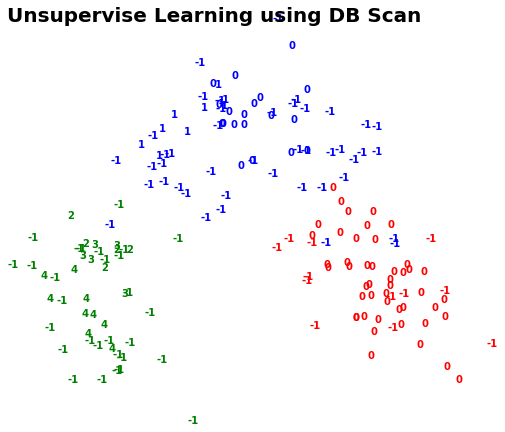

In [0]:
y_pred = DBSCAN(eps=2, min_samples=5).fit_predict(X_std)
pca_plot(X_std,y,y_pred,'Unsupervise Learning using DB Scan')

#4. GMM Clustering

Testing for n component
- ARI score for GMM  of ncomponent = 3 is the highest at 0.880
- Silhouette score for GMM of ncomponent = 3 is highest with 0.284

In [0]:
from sklearn.mixture import GaussianMixture

comp = np.arange (2,6,1)
for ind in comp:
  # Defining the agglomerative clustering with fixed min_sample = 5
  gmm_cluster = GaussianMixture(n_components=ind, random_state=123)
  # Fit model
  y_pred = gmm_cluster.fit_predict(X_std)
  print ("ARI score of GMM Clustering using ncomponent {} is {}".format(ind,metrics.adjusted_rand_score(y, y_pred)))

ARI score of GMM Clustering using ncomponent 2 is 0.4394391043947633
ARI score of GMM Clustering using ncomponent 3 is 0.8803997758776985
ARI score of GMM Clustering using ncomponent 4 is 0.7853835095234392
ARI score of GMM Clustering using ncomponent 5 is 0.6670131496287695


In [0]:
comp = np.arange (2,6,1)
for ind in comp:
  # Defining the agglomerative clustering with fixed min_sample = 5
  gmm_cluster = GaussianMixture(n_components=ind, random_state=123)
  # Fit model
  y_pred = gmm_cluster.fit_predict(X_std)
  print ("silhouette score of GMM Clustering using ncomponent {} is {}".format(ind,metrics.silhouette_score(X_std, y_pred, metric='euclidean')))

silhouette score of GMM Clustering using ncomponent 2 is 0.2682319543159216
silhouette score of GMM Clustering using ncomponent 3 is 0.2844212860533542
silhouette score of GMM Clustering using ncomponent 4 is 0.269480613215842
silhouette score of GMM Clustering using ncomponent 5 is 0.21207820359120708


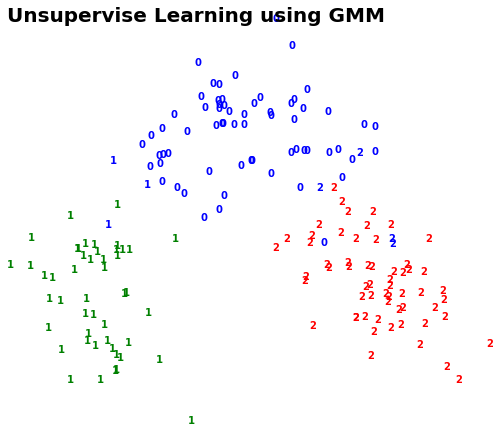

In [0]:
y_pred = GaussianMixture(n_components=3, random_state=123).fit_predict(X_std)
pca_plot(X_std,y,y_pred,'Unsupervise Learning using GMM')

# Summary

Using an unsupervised ML flow on the Wine segmention dataset the following results were achieved: 

- Dimensional Reduction method, in general, performed well in depicting three cluster patterns
- UMAP dimensional reduction overall gave the best separation (visually) 
- From clustering techniques, an overall consistent result (number of clusters equals to 3) is observed. 
- K means clusteric technique gave the best ARI and Silhouette Score followed by GMM and agglomerate clustering. DBSCAN performed poorly in identifying the clustering patterns.